#### **Description**

In [1]:
print('Name:Leo pauly')
print('Description: Program for implementing Flow-PINN')

Name:Leo pauly
Description: Program for implementing Flow-PINN


For reference, PINN & SciANN package tutorial: https://www.youtube.com/watch?v=20NEQFcdp3o&ab_channel=DesignSafe-CIMedia

#### **Install**

This will install SciANN library and all the dependecies

In [2]:
#!pip install sciann

#### **Import**

In [3]:
import numpy as np
np.random.seed(64)
import matplotlib.pyplot as plt 
import sciann as sn 
import pandas as pd
from numpy import pi
from sciann.utils.math import diff, sign, sin
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
np.set_printoptions(suppress=True)

---------------------- SCIANN 0.6.3.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 


Run the following only if using google Colab. It will ennable you to load data from google drive. Ignore if running on you local machine. 

In [4]:
#from google.colab import drive
#drive.mount('/content/gdrive')

#### **Flow-PINN** 

Details of defining functionls is available here: https://www.sciann.com/getting-started/functional-guide/

Details of deifing the model can be found here: https://www.sciann.com/scimodels/#scimodel



##### **Dimensions**


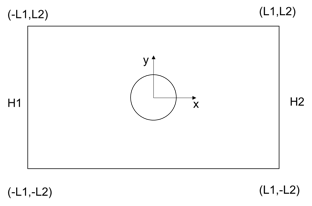

In [5]:
L1=1
L2=.5
H1=1
H2=0

##### **Inputs:** x,y 

##### **Outputs:** v (x,y) (Darcy's velocity); K(x,y) (hydraulic conductivity); h (x,y)(pressure head)

In [6]:
x = sn.Variable('x',dtype='float64')
y = sn.Variable('y',dtype='float64')
v = sn.Functional('v', [x,y], 2*[20], 'relu')
K = sn.Functional('K', [x,y], 2*[20], 'relu')
h = sn.Functional('h', [x,y], 2*[20], 'relu')

##### **Darcy's Equation:**


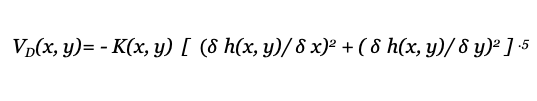

In [7]:
d1 = sn.Data(v)
d2 = sn.Data(K)
d3 = sn.Data(h)
pde1=pow(diff(h, x),2)
pde2=pow(diff(h, y),2)
C1 = -v-(K*(pow(pde1+pde2,.5)))

**Boundary Conditions:**

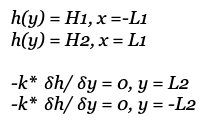

In [8]:
TOL = 0.001

B1 = (1 - sign(x - (-L1+TOL))) * (h-H1)
B2 = (1 + sign(x - (L1-TOL))) * (h-H2)

B3 = (1 - sign(y - (-L2+TOL))) * (-K*diff(h,y))
B4 = (1 + sign(y - (L2-TOL))) * (-K*diff(h,y))

Visualising boundary condition functions used:

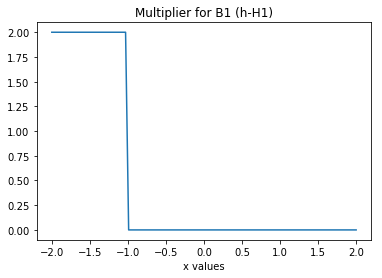

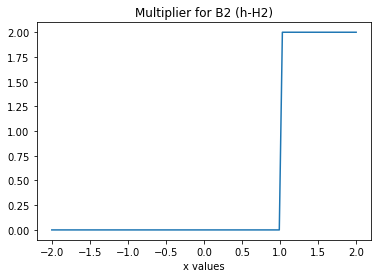

In [9]:
psuedo_x=np.linspace(-2,2,100)

psuedo_x_multiplier_B1=(1 - np.sign(psuedo_x - (-L1+TOL))) 
plt.plot(psuedo_x,psuedo_x_multiplier_B1)
plt.title('Multiplier for B1 (h-H1)')
plt.xlabel('x values')
plt.show()

psuedo_x_multiplier_B2=(1 + np.sign(psuedo_x - (L1-TOL))) 
plt.plot(psuedo_x,psuedo_x_multiplier_B2)
plt.title('Multiplier for B2 (h-H2)')
plt.xlabel('x values')
plt.show()

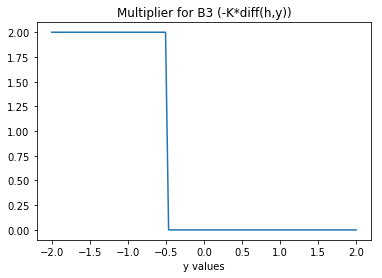

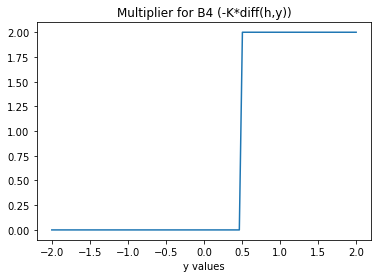

In [10]:
psuedo_y=np.linspace(-2,2,100)

psuedo_y_multiplier_B3=(1 - np.sign(psuedo_y - (-L2+TOL)))
plt.plot(psuedo_y,psuedo_y_multiplier_B3)
plt.title('Multiplier for B3 (-K*diff(h,y))')
plt.xlabel('y values')
plt.show()

psuedo_y_multiplier_B4=(1 + np.sign(psuedo_y - (L2-TOL))) 
plt.plot(psuedo_y,psuedo_y_multiplier_B4)
plt.title('Multiplier for B4 (-K*diff(h,y))')
plt.xlabel('y values')
plt.show()

######  **Model definition**

In [11]:
m = sn.SciModel([x,y], [d1,d2,d3,C1,B1,B2,B3,B4],loss_func='mse',plot_to_file='./Flow-PINN.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


#### **Dataset**

Datasets in .xlxs format are loaded using pandas python library: https://pandas.pydata.org/

In [15]:
v_data_df=pd.read_excel('./Darcy_Flux.xlsx')#('/content/gdrive/My Drive/Colab Notebooks/PINN/Darcy_Flux.xlsx')  
h_data_df=pd.read_excel('./Hydraulic_Head.xlsx')#('/content/gdrive/My Drive/Colab Notebooks/PINN/Hydraulic_Head.xlsx')  

In [16]:
x1_data=np.array(v_data_df['X'].values)
x2_data=np.array(v_data_df['Y'].values)

v_data=np.array(v_data_df['VINIT'].values)
print('v_data:',v_data.shape)

K_data=[]
for i in range(len(x1_data)):
  if ((x1_data[i]*x1_data[i])+(x2_data[i]*x2_data[i])<=(.25*L2)):
    K_data.append(0)
  else:
    K_data.append(.5)
K_data=np.array(K_data)
print('K_test:',K_data.shape)

h_data=np.array(h_data_df['FINIT'].values)
print('h_data:',h_data.shape)

v_data: (910,)
K_test: (910,)
h_data: (910,)


**Visualizing data**

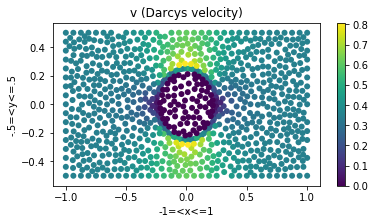

In [17]:
fig = plt.figure(figsize=(6, 3))
plt.scatter(x1_data, x2_data, c=v_data, cmap='viridis',linewidths=.0001)
plt.xlabel('-1=<x<=1')
plt.ylabel('-.5=<y<=.5')
plt.title('v (Darcys velocity)')
plt.colorbar()
plt.show()

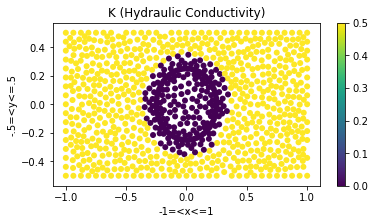

In [18]:
fig = plt.figure(figsize=(6, 3))
plt.scatter(x1_data, x2_data, c=K_data, cmap='viridis',linewidths=.0001)
plt.xlabel('-1=<x<=1')
plt.ylabel('-.5=<y<=.5')
plt.title('K (Hydraulic Conductivity)')
plt.colorbar()
plt.show()

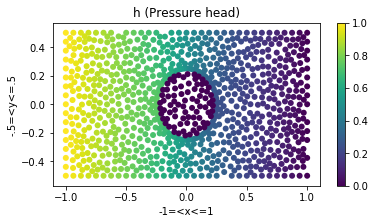

In [19]:
fig = plt.figure(figsize=(6, 3))
plt.scatter(x1_data, x2_data, c=h_data, cmap='viridis',linewidths=.0001)
plt.xlabel('-1=<x<=1')
plt.ylabel('-.5=<y<=.5')
plt.title('h (Pressure head)')
plt.colorbar()
plt.show()

In [20]:
train_test_ratio=.7
x1_train, x1_test,x2_train, x2_test, v_train, v_test,K_train, K_test,h_train, h_test = train_test_split(x1_data,x2_data, v_data,K_data,h_data, train_size=train_test_ratio, random_state=512)
print('test:train ratio:',train_test_ratio)
print('Training sizes(x1,x2,v,K,h):',x1_train.shape,x2_train.shape,v_train.shape,K_train.shape,h_train.shape)
print('Testing sizes(x1,x2,v,K,h):',x1_test.shape,x2_test.shape,v_test.shape,K_test.shape,h_test.shape)
C1_train=B1_train=B2_train=B3_train=B4_train = 'zeros'
C1_test=B1_test=B2_test=B3_test=B4_test = np.zeros(x1_test.shape)

test:train ratio: 0.7
Training sizes(x1,x2,v,K,h): (637,) (637,) (637,) (637,) (637,)
Testing sizes(x1,x2,v,K,h): (273,) (273,) (273,) (273,) (273,)


In [21]:
v_pred = v.eval(m, [x1_test,x2_test])
h_pred = h.eval(m, [x1_test,x2_test])
K_pred = K.eval(m, [x1_test,x1_test])
print('MSE for v before training:',(mean_squared_error(v_test,v_pred)))
print('MSE for h before training:',(mean_squared_error(h_test,h_pred)))
print('MSE for K before training:',(mean_squared_error(K_test,K_pred)))

MSE for v before training: 0.20113480174601095
MSE for h before training: 1.4620019899410082
MSE for K before training: 0.34342304804758883


#### **Training**

Details of the model.train function can be found here: https://www.sciann.com/scimodels/#train

In [22]:
learning_rate=0.001
epochs=50
print('================ Training: Start ================')
history = m.train([x1_train,x2_train], [v_train,K_train,h_train,C1_train,B1_train,B2_train,B3_train,B4_train], learning_rate=learning_rate, epochs=epochs, verbose=0,batch_size=100,validation_data=([x1_test,x2_test],[v_test,K_test,h_test,C1_test,B1_test,B2_test,B3_test,B4_test]))
print('================ Training: End ================')

================ Training: Start ================

Total samples: 637 
Batch size: 100 
Total batches: 7 



/home/home01/cnlp/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


================ Training: End ================


#### **Plotting Loss**

In [23]:
print(history.history.keys())

dict_keys(['loss', 'v_loss', 'K_loss', 'h_loss', 'sub_loss', 'mul_3_loss', 'mul_4_loss', 'mul_7_loss', 'mul_10_loss', 'val_loss', 'val_v_loss', 'val_K_loss', 'val_h_loss', 'val_sub_loss', 'val_mul_3_loss', 'val_mul_4_loss', 'val_mul_7_loss', 'val_mul_10_loss', 'lr', 'time'])


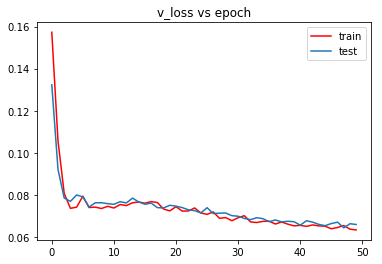

In [24]:
plt.plot(range(0,epochs),history.history['v_loss'],color='red',label='train')
plt.plot(range(0,epochs),history.history['val_v_loss'],label='test')
plt.title('v_loss vs epoch')
plt.legend()
plt.show()

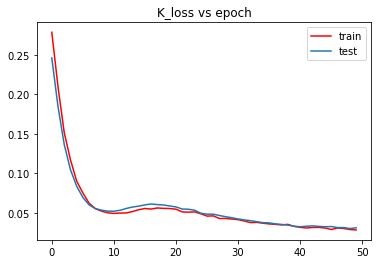

In [25]:
plt.plot(range(0,epochs),history.history['K_loss'],color='red',label='train')
plt.plot(range(0,epochs),history.history['val_K_loss'],label='test')
plt.title('K_loss vs epoch')
plt.legend()
plt.show()

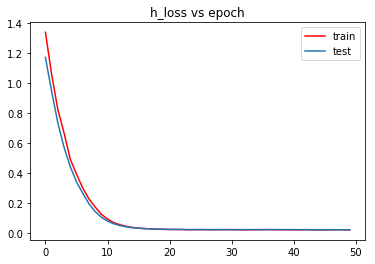

In [26]:
plt.plot(range(0,epochs),history.history['h_loss'],color='red',label='train')
plt.plot(range(0,epochs),history.history['val_h_loss'],label='test')
plt.title('h_loss vs epoch')
plt.legend()
plt.show()

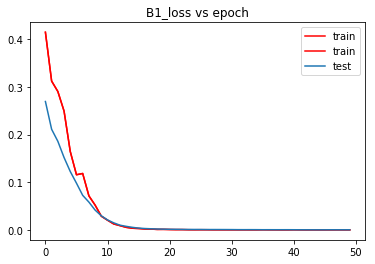

In [29]:
plt.plot(range(0,epochs),history.history['mul_3_loss'],color='red',label='train')
plt.plot(range(0,epochs),history.history['val_mul_3_loss'],label='test')
plt.title('B1_loss vs epoch')
plt.legend()
plt.show()

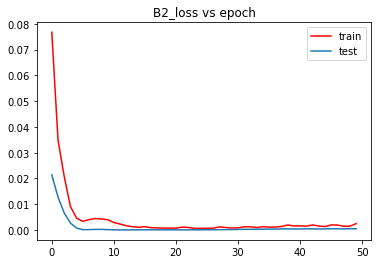

In [30]:
plt.plot(range(0,epochs),history.history['mul_4_loss'],color='red',label='train')
plt.plot(range(0,epochs),history.history['val_mul_4_loss'],label='test')
plt.title('B2_loss vs epoch')
plt.legend()
plt.show()

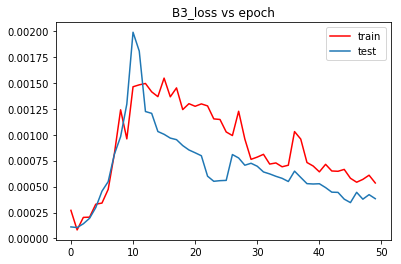

In [31]:
plt.plot(range(0,epochs),history.history['mul_7_loss'],color='red',label='train')
plt.plot(range(0,epochs),history.history['val_mul_7_loss'],label='test')
plt.title('B3_loss vs epoch')
plt.legend()
plt.show()

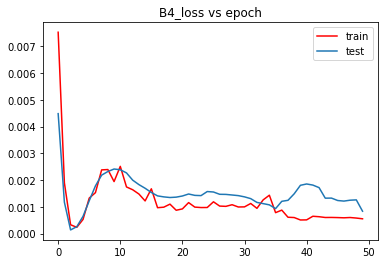

In [32]:
plt.plot(range(0,epochs),history.history['mul_10_loss'],color='red',label='train')
plt.plot(range(0,epochs),history.history['val_mul_10_loss'],label='test')
plt.title('B4_loss vs epoch')
plt.legend()
plt.show() 

In [33]:
plt.plot(range(0,epochs),history.history['sub_loss'],color='red',label='train')
plt.plot(range(0,epochs),history.history['val_sub_loss'],label='test')
plt.legend()
plt.title('PDE loss vs epoch')
plt.show()

KeyError: 'sub_8_loss'

In [ ]:
plt.plot(range(0,epochs),history.history['loss'],color='red',label='train')
plt.plot(range(0,epochs),history.history['val_loss'],label='test')
plt.title('Net loss vs epoch')
plt.legend()
plt.show()

#### **Testing** 

In [ ]:
v_pred = v.eval(m, [x1_test,x2_test])
h_pred = h.eval(m, [x1_test,x2_test])
K_pred = K.eval(m, [x1_test,x2_test])
print('MSE for v after training:',round(mean_squared_error(v_test,v_pred),10))
print('MSE for h after training:',round(mean_squared_error(h_test,h_pred),10))
print('MSE for K after training:',round(mean_squared_error(K_test,K_pred),10))


In [ ]:
fig = plt.figure(figsize=(6, 3))
plt.scatter(x1_test, x2_test, c= v.eval(m, [x1_test,x2_test]), cmap='viridis',linewidths=.0001)
plt.xlabel('-1=<x<=1')
plt.ylabel('-.5=<y<=.5')
plt.title('v_pred (Darcy velocity)')
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(6, 3))
plt.scatter(x1_test, x2_test, c= v_test, cmap='viridis',linewidths=.0001)
plt.xlabel('-1=<x<=1')
plt.ylabel('-.5=<y<=.5')
plt.title('v_test (Darcy velocity)')
plt.colorbar()
plt.show()

In [ ]:
fig = plt.figure(figsize=(6, 3))
plt.scatter(x1_test, x2_test, c= K.eval(m, [x1_test,x2_test]), cmap='viridis',linewidths=.0001)
plt.xlabel('-1=<x<=1')
plt.ylabel('-.5=<y<=.5')
plt.title('K_pred (Hydraulic Conductivity)')
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(6, 3))
plt.scatter(x1_test, x2_test, c= K_test, cmap='viridis',linewidths=.0001)
plt.xlabel('-1=<x<=1')
plt.ylabel('-.5=<y<=.5')
plt.title('K_test (Hydraulic Conductivity)')
plt.colorbar()
plt.show()

In [ ]:
fig = plt.figure(figsize=(6, 3))
plt.scatter(x1_test, x2_test, c= h.eval(m, [x1_test,x2_test]), cmap='viridis',linewidths=.0001)
plt.xlabel('-1=<x<=1')
plt.ylabel('-.5=<y<=.5')
plt.title('h_pred (Pressure head)')
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(6, 3))
plt.scatter(x1_test, x2_test, c= h_test, cmap='viridis',linewidths=.0001)
plt.xlabel('-1=<x<=1')
plt.ylabel('-.5=<y<=.5')
plt.title('h_test (Pressure head)')
plt.colorbar()
plt.show()

#### **Simulating**


In [ ]:
x1_sim, x2_sim = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-.5, .5, 100))
fig = plt.figure(figsize=(6, 3))
v_pred_sim =np.array(v.eval(m, [x1_sim,x2_sim]))
plt.contourf(x1_sim, x2_sim, v_pred_sim)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Darcys Veloctiy')
plt.show()

In [ ]:
x1_sim, x2_sim = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-.5, .5, 100))
fig = plt.figure(figsize=(6, 3))
v_pred_sim =np.array(K.eval(m, [x1_sim,x2_sim]))
plt.contourf(x1_sim, x2_sim, v_pred_sim)
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
plt.title('Hydraulic Conductivty')
plt.show()

In [ ]:
x1_sim, x2_sim = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-.5, .5, 100))
fig = plt.figure(figsize=(6, 3))
v_pred_sim =np.array(h.eval(m, [x1_sim,x2_sim]))
plt.contourf(x1_sim, x2_sim, v_pred_sim)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Pressure head')
plt.show()

In [ ]:
print(x1_sim.shape,x2_sim.shape,v_pred_sim.shape)